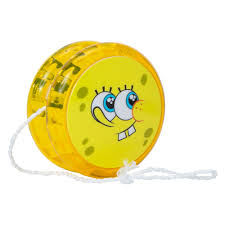  

# Data processing CTD YoYo sampling

Carlos Schettini, 16-Apr-2025

We operate a CTD by JFE Advantech, model Rinko Profiler. The CTD can recod data at 10 Hz. It is pretty small, so we put in a cage with some ballast.   
When navigating, the boat slows down and we cast the ctd at free-fall until it touch the bottom, than we pull it back with the boat moving slowly forwards...  
We repeat it as many as we want...  We record the boat track with a hand held GPS, so we can geo-reference the CTD data.  
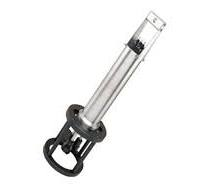

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.parser import parse
import datetime
import pickle
from scipy.interpolate import griddata

## Load the CTD CSV file, and GPS GPX file

In [2]:
with open('CTD_yoyo.csv') as io:
    ctd = io.readlines()

with open('GPS_Track.gpx') as io:
    gpx = io.readlines()

## Process the GPX file to extract all coordinates in it, and the time of each!

GPS record time in UTC. CTD record time as chosen... here we used local time = UTC - 3  
Not all GPX are the same... they are ASCII, but you may have a slightly different format!

In [3]:
gps = []
for i, li in enumerate(gpx):
    if '<trkpt lat=' in li:
        liq = li.split('"')
        
        latitude = np.float64(liq[1])
        longitude = np.float64(liq[3])
         
        liq = gpx[i+2].split('>')
        strtime = liq[1][:-7]

        ######################################################
        # correct to the local time
        time = parse(strtime) - datetime.timedelta(hours = 3)
        
        gps.append([time, longitude, latitude])

gps = np.array(gps)

Text(0.5, 1.0, 'Whole GPS track')

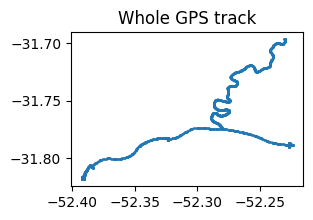

In [4]:
plt.figure(figsize=(3,2))
plt.plot(gps[:,1], gps[:,2], '.', ms=1)
plt.title('Whole GPS track')

## Process the CTD CSV file

In [5]:
trigger = 0
data = []
for i, li, in enumerate(ctd):
    
    if 'Measurement Date/Time,Press. [dbar]' in li:
        trigger = 1
        header = li.split(',') # get the header
        continue
        
    if trigger == 1:
        
        if 'Error' in li:
            continue
        else: 
            liq = li.split(',')
            time = parse(liq[0])
            variables = [np.float64(x) for x in liq[1:-1]]
            variables.insert(0, time)
            data.append(variables)
            
data = np.array(data)

## The CTD fields

In [6]:
for i, h in enumerate(header):
    print(i, h)

0 Measurement Date/Time
1 Press. [dbar]
2 Temp. [â„ƒ]
3 Salinity
4 Cond. [mS/cm]
5 EC25 [Î¼S/cm]
6 Density [kg/m3]
7 SigmaT
8 Chl-Flu. [ppb]
9 Chl-a [Î¼g/L]
10 Turb. [FTU]
11 DO [%]
12 DO [mg/L]
13 DO [Î¼mol/L]
14 Batt. [V]



## Checking the CTD pressure 
So... we have done 10 casts in this section

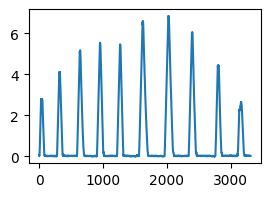

In [7]:
# this CTD usually has a 'offset' of the pressure. This is to adjust to zero (surface)!
data[:,1] = data[:,1] - np.min(data[:,1])

plt.figure(figsize=(3,2))
plt.plot(data[:,1])

## Checking if the CTD time is 'in' the GPS time... 
Otherwise the rest will not work

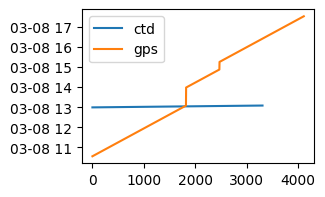

In [8]:
plt.figure(figsize=(3,2))
plt.plot(data[:,0], label='ctd')
plt.plot(gps[:,0], label='gps')
plt.legend()

## Separating the vertical profiles

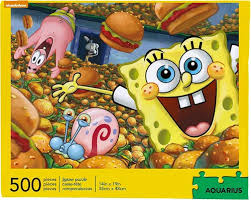

This is a bit puzzling...   


You may find a clever way to do that... but at the end, I think the better option is doing it
mannualy identifying the separations, especially you need to inspect the profiles and identify if
all are good... we need use the 'plt.ginput', and to use it with Jupyter there a little trick!

We need use a 'active' window to capture information from the plot! But after you do it, you need change back to online plots (if you want!)

https://stackoverflow.com/questions/41403406/matplotlib-use-of-ginput-on-jupyter-matplotlib-notebook

In [9]:
# after run, comment... otherwise can freeze the notebook
# import matplotlib
# matplotlib.use('TkAgg')

In [24]:
###################
# for digitizing 

# %matplotlib qt  
# # to do an external active plot, comment after use the ginput

# plt.figure(figsize=(3,2))
# plt.plot(data[:,1])
# points = plt.ginput(-1,-1) 

# points2 = np.array(points)[:,0]
# points2 = [int(x) for x in points2]
# print(points2)

# with open('CTD_casts_idxs.pkl', 'wb') as io:
#     pickle.dump(points2, io)

[(np.float64(0.8895161290321312), np.float64(0.035197324192834945)), (np.float64(272.4143145161288), np.float64(0.00498502874834128)), (np.float64(585.5239919354838), np.float64(0.04526808934099935)), (np.float64(898.6336693548385), np.float64(0.015055793896505909)), (np.float64(1214.1895161290322), np.float64(0.035197324192834945)), (np.float64(1559.0993951612904), np.float64(0.015055793896505909)), (np.float64(1962.7173387096773), np.float64(0.025126559044670316)), (np.float64(2332.0889112903224), np.float64(0.035197324192834945)), (np.float64(2755.2762096774195), np.float64(0.015055793896505909)), (np.float64(3097.7399193548385), np.float64(0.025126559044670316)), (np.float64(3273.8641129032258), np.float64(0.025126559044670316))]


When 'qt' is active, the plot will be displayed in a active window.    
Using the mouse, when you click in the figure you´re getting the x,y coordinates  
Digitize where the profiles starts, since this will use to find the time of each cast  
Add a last point at the end of the data, which will be useful later during the separation  
After finishing, press enter to out the digitizing mode (the red dots will desapear)  
The points (x,y) are stored in 'points' as a tuple, and floats. We need only the x as integers  
After that, we save the result using pickle, to load them and continue...
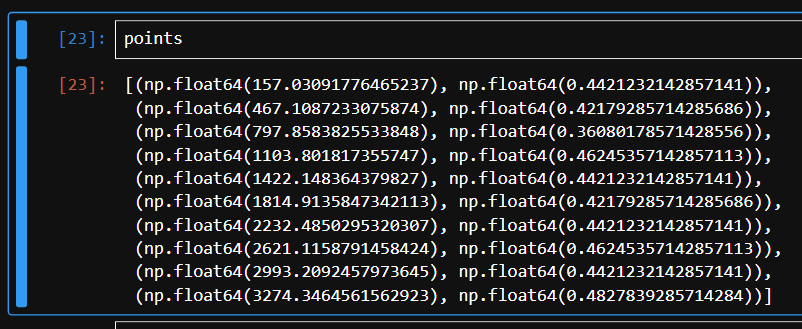

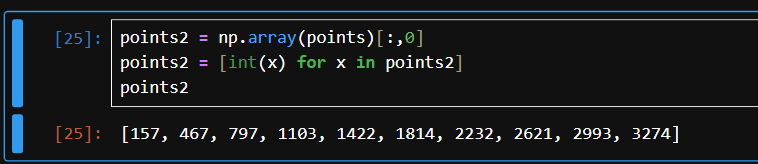

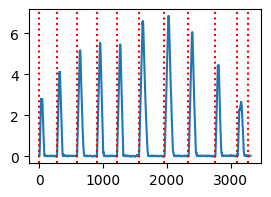

In [27]:
########################
# after digitizing

%matplotlib inline   
# to do plots inline (in the Jupyter), uncomment after use the ginput to keep doing inline plots

# this must be executed only after the digitizing and pickle.dump...
# let it commented initially. 
with open('CTD_casts_idxs.pkl', 'rb') as io:
    idx_casts = pickle.load(io)

plt.figure(figsize=(3,2))
plt.plot(data[:,1])

# here we can check the cast separations!
for i in idx_casts:
    plt.axvline(i, color='r', ls=':')

In the figure above, the dotted red vertical lines indicate where you digitized the cast-start index, what will be used the get the time for   
this cast. The last is just to help the separation (see below)

### Now we can separate the profiles
We need also to have a time for each cast, which will be used to synchronyze with the GPS and find the distance...

In [30]:
casts = []
casts_time = []
for i in range(len(idx_casts)-1):
    # slicing the casts from the data
    sliced_data = data[idx_casts[i]:idx_casts[i+1],:]
    casts.append(sliced_data)
    casts_time.append(sliced_data[0,0])

print('number of casts : ', len(casts))

number of casts :  10


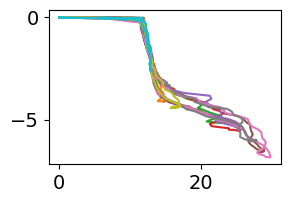

In [159]:
# just checking...
plt.figure(figsize=(3,2))
for c in casts:
    plt.plot(c[:,3], -c[:,1])

## Syncronyzing the CTD with GPS (with 'safe' issue, first!)

In [33]:
# for interpolation, we cannot use the datetime... need use floats.
t_ctd = mdates.date2num(casts_time)
t_gps = mdates.date2num(gps[:,0])

# with error!
longitude = np.interp(t_ctd, t_gps, gps[:,1])
latitude = np.interp(t_ctd, t_gps, gps[:,2])

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [34]:
print(type(t_ctd[0]), 
      type(t_gps[0]),
      type(gps[0,1]),
      gps[:,1].dtype,
      type(np.array(gps[:,1], dtype='float64')))

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> object <class 'numpy.ndarray'>


The problem with the 'Safe' is originated when I merged datetime and floats creating the list during the processing.   
When I converted the list in array, because the datetime objects, 
the dtype=object. So, to fix this, even the elements in the are floats, we need re-create the column specifying it as dtype='float64'!

In [47]:
# We cannot interpolat datetime objects... need to convert to floats.
t_ctd = mdates.date2num(casts_time)
t_gps = mdates.date2num(gps[:,0])

# fixing the 'safe' error
longitude = np.interp(t_ctd, t_gps, np.array(gps[:,1], dtype='float64'))
latitude = np.interp(t_ctd, t_gps, np.array(gps[:,2], dtype='float64'))

# calculating the distance in meters
distance_pts = (np.diff(longitude)**2 + np.diff(latitude)**2)**.5  * 111120  # 1 degree = 60 minuts / 1 minut = 1 nautical mile = 1852 m
distance = np.cumsum(distance_pts)
distance = np.insert(distance, 0, 0) # to start at zero!


Text(0.5, 1.0, 'Casts positions')

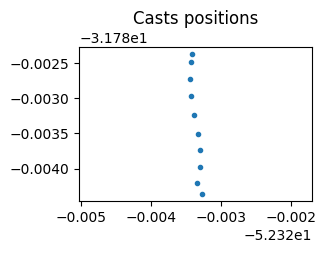

In [38]:
plt.figure(figsize=(3,2))
plt.plot(longitude, latitude, '.')
plt.axis('equal')
plt.title('Casts positions')

# Processing the CTD casts
From now on, is is about the same as we proceed with a longitudinal survey with multiple CTD casts...  
https://gutoschettini.github.io/IPYNB-Collection/09_Figure_AXES_loop_setup.html

In [111]:
casts_rdx = []  # to keep the list of casts after reduction
casts_mtx = np.zeros((1,7)) # to merge the casts in a single set. This is a seed array
casts_depth = [] # to keep the maximum pressure = depth
for i,d in enumerate(casts): 
    pressure_ref = .3 # to eliminate the top
    down_cast = []
    for j in range(len(d)):
        if d[j,1] > pressure_ref:
            # separating [pressure temperature salinity chlorophyll turbidity oxygen%], and including the distance
            new_line = np.array([distance[i]] + d[j,1:4].tolist() + d[j,9:12].tolist() )
            down_cast.append(new_line)
            pressure_ref = d[j,1]
    
    down_cast = np.array(down_cast)
    down_cast = down_cast[down_cast[:,1] < pressure_ref - 0.3] # to eliminate the near bottom
    casts_mtx = np.vstack((casts_mtx, down_cast))
    casts_depth.append(down_cast[-1,1])
    casts_rdx.append(down_cast)

# to rid from the seed
casts_mtx = casts_mtx[1:,:]


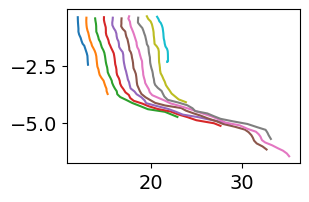

In [115]:
# checking...
plt.figure(figsize=(3,2))
for i, c in enumerate(casts_rdx):
    plt.plot(c[:,3]+i, -c[:,1])

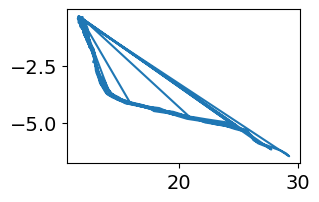

In [117]:
# checking
plt.figure(figsize=(3,2))
plt.plot(casts_mtx[:,3], -casts_mtx[:,1])

## The cross section (up side down!)

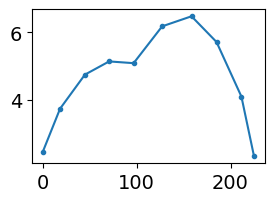

In [118]:
plt.figure(figsize=(3,2))
plt.plot(distance, casts_depth, '.-')

## Creating the mask for the bottom!

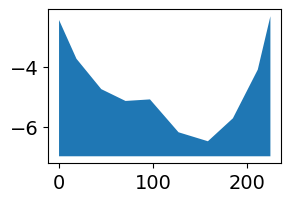

In [160]:
max_depth = np.max(casts_depth)

mask_x = np.array([distance.tolist() + [distance[-1], distance[0], distance[0]]])[0]
mask_z = np.array([casts_depth + [max_depth + .5, max_depth + .5, casts_depth[0]]])[0]

plt.figure(figsize=(3,2))
plt.fill(mask_x, -mask_z)

## Interpolation

In [155]:
points = casts_mtx[:,:2]

xi = np.linspace(np.min(points[:,0]), np.max(points[:,0]), 50)
zi = np.linspace(np.min(points[:,1]), np.max(points[:,1]), 30)

xx, zz = np.meshgrid(xi, zi)

dists = []
for i in range(2,7):
    dists.append( griddata(points, casts_mtx[:,i], (xx, zz), method='linear') )

# changing the orther salinity, temperature, turbidity, chlorophyll, ox
dists[1], dists[0], dists[2], dists[3] = dists[0], dists[1], dists[3], dists[2]

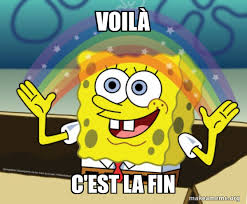

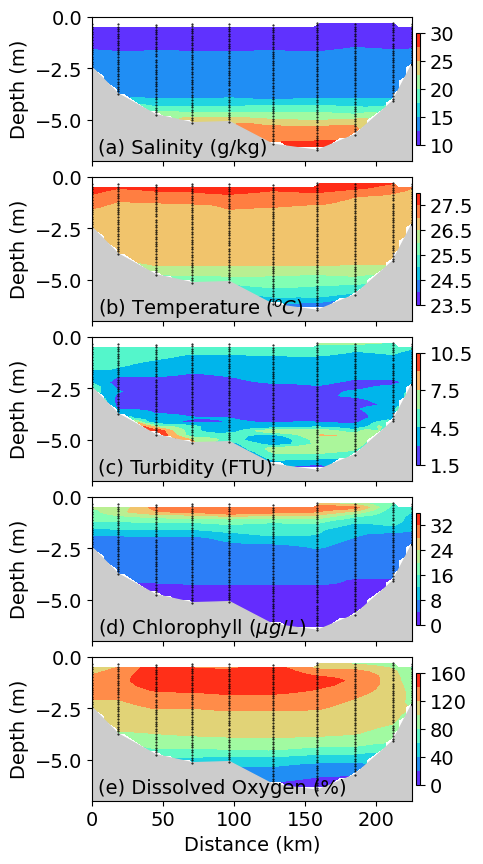

In [161]:
plt.rcParams.update({'font.size':14})
variables = [r'(a) Salinity (g/kg)', r'(b) Temperature ($^oC$)', r'(c) Turbidity (FTU)', r'(d) Chlorophyll ($\mu g/L$)', r'(e) Dissolved Oxygen (%)']

fig = plt.figure(figsize=(4,8))

# axis positions
px = .1
py = .8
dx = .8
dy = .18
dint = .02

# colorbar positions
pxcb = px + dx + 0.01
dxcb = 0.01
fc = .02 # to reduce it a little

axs = []
cbaxs = []
for i in range(5):
    # create the axes
    axs.append( 
                fig.add_axes( [px, py-(dy+dint)*i, dx, dy] )
                )
    # create the colorbar axes  
    cbaxs.append(
                fig.add_axes( [pxcb, py-(dy+dint)*i+fc, dxcb, dy-fc*2] )
                )

    cb = axs[i].contourf(xi, -zi, dists[i], cmap='rainbow')
    axs[i].fill(mask_x, -mask_z, color=[.8,.8,.8])
    
    cbar = plt.colorbar(cb, cax=cbaxs[i])
    cbar.ax.locator_params(nbins=5)

    axs[i].plot(points[:,0], -points[:,1], '.k', ms=1)
    
    axs[i].set_ylabel('Depth (m)')
    axs[i].set_ylim(-np.max(mask_z), 0)
    axs[i].text(.02, .05, variables[i], transform=axs[i].transAxes)
    
    if i < 4:
        axs[i].set_xticklabels('')
    if i == 4:
        axs[i].set_xlabel('Distance (km)')